# Abstract

This project aims to investigate the differences in electroencephalography (EEG) signals between individuals with Alzheimer’s disease (AD) and controls. We used two datapoints from Mitiadous et al. (2023), which contains scalp EEG recordings of AD patients, and healthy controls under eyes-closed rest. In this project, we will first apply signal processing techniques including filtering and artifact rejection remove noise and isolate the frequency range of interest. Our methodology includes the application of the discrete Fourier transform (DFT) to examine spectral components, followed by the computation of power spectral density (PSD) via the Welch method. Through this approach, we aim to quantify the relative band power across different frequency bands, allowing for a detailed comparison of neural activity between the two subjects.

# Exploratory Data Analysis

Below is the dataset description provided by our TA:

>This dataset provides resting-state EEG recordings from individuals with Alzheimer’s disease (AD), frontotemporal dementia (FTD), and healthy controls, collected using a clinical EEG system with 19 scalp electrodes during an eyes-closed resting state. The dataset includes 36 AD patients, 23 FTD patients, and 29 healthy age-matched subjects, with Mini-Mental State Examination (MMSE) scores reported for each. EEG signals were recorded using a monopolar montage, and both raw and preprocessed EEG data are available in BIDS format. Preprocessing involved artifact subspace reconstruction and independent component analysis for denoising. This dataset has high reuse potential for studying EEG-based biomarkers for dementia, brain connectivity alterations, and machine learning applications in neurodegenerative disease diagnosis.
>
>- Two individual EEG data included(Alzheimer’s disease - subject_001, Healthy Control - subject_027)
>- The sampling rate was 500 Hz and the resolution was 10 uV/mm
>- Three channel included: Fp1','Fp2','F3'

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, firwin, filtfilt, welch, freqz, lfilter

np.random.seed = 118
F_s = 500

Load in the dataset and transform it into a pandas dataframe.

In [17]:
Control = np.load("./dataset/Control_EEG_sub_027.npy")
AD = np.load("./dataset/AD_EEG_sub_001.npy")

feature_names = ['Fp1', 'Fp2', 'F3']
df_control = pd.DataFrame(Control.T, columns=feature_names)
df_AD = pd.DataFrame(AD.T, columns=feature_names)

df_AD.head()

,Fp1,Fp2,F3
0,-0.000190,-0.000142,-0.000107
1,-0.000180,-0.000137,-0.000100
2,-0.000167,-0.000135,-0.000106
3,-0.000160,-0.000133,-0.000105
4,-0.000159,-0.000124,-0.000104


Since the usual measurement for EEG studies is $\mu V$, we upscale the entire dataset by $10^6$

In [18]:
df_AD *= 1e6
df_control *= 1e6
df_AD.head()

,Fp1,Fp2,F3
0,-189.892563,-141.845688,-107.373039
1,-180.419907,-137.353500,-100.048820
2,-166.992172,-135.058578,-105.761711
3,-160.205063,-132.958969,-105.322258
4,-159.326157,-124.462883,-104.150383


Display the raw EEG data of two subjects.

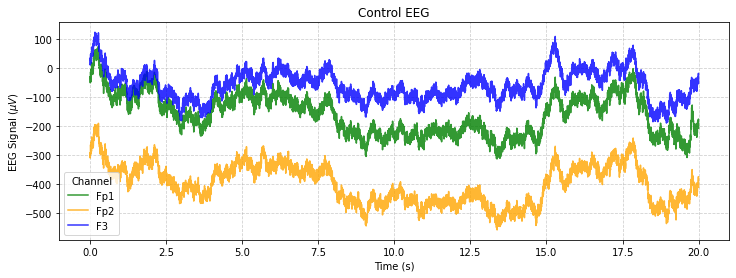

In [19]:
def plot_EEG (df,title):
    t = df.index/F_s
    plt.figure(figsize=(12, 4))
    plt.plot(t,df["Fp1"], color = "green", label = "Fp1", alpha = 0.8)
    plt.plot(t,df["Fp2"], color = "orange", label = "Fp2", alpha = 0.8)
    plt.plot(t,df["F3"], color = "blue", label = "F3", alpha = 0.8)
    plt.xlabel('Time (s)')
    plt.ylabel(r'EEG Signal $(\mu V)$')
    plt.title(title)
    plt.legend(title="Channel")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

plot_EEG(df_control, "Control EEG")

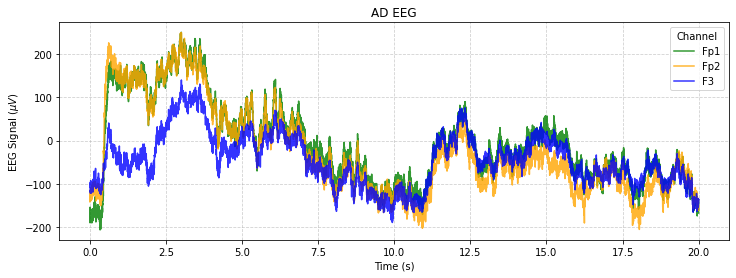

In [20]:
plot_EEG(df_AD, "AD EEG")

The unprocessed data shows signs of high-frequency noise as the range of the signal varies from $\pm 200 \mu V$, which is abnormal for calm state EEG. Preprocessing and cleaning is needed before doing further analysis.

# Preprocessing
In the original dataset paper, a preprocessing pipeline is applied as the following:

> First, a Butterworth band-pass filter 0.5-45 Hz was applied and the signals were re-referenced to A1-A2. Then, the Artifact Subspace Reconstruction routine (ASR) which is an EEG artifact correction method included in the EEGLab Matlab software was applied to the signals, removing bad data periods which exceeded the max acceptable 0.5 second window standard deviation of 17, which is considered a conservative window. Next, the Independent Component Analysis (ICA) method (RunICA algorithm) was performed, transforming the 19 EEG signals to 19 ICA components. ICA components that were classified as “eye artifacts” or “jaw artifacts” by the automatic classification routine “ICLabel” in the EEGLAB platform were automatically rejected. It should be noted that, even though the recording was performed in a resting state, eyes-closed condition, eye artifacts of eye movement were still found at some EEG recordings.

Since we do not have the whole data set, we will be focusing on the filtering part.

In [21]:
lowcut = 0.5
highcut = 45

## Why Not a FIR Filter
In class we learned a lot a bout finite __impulse response filters__ (FIR), but the paper used a __infinite response filter__ (IIR). One major reason is because FIR filters need a very high order to achieve the same cutoff as a IIR filter. Since in the study we care more about the lower frequency range, the lower end is set to be 0.5 Hz, which a normal FIR filter struggles to do so. Take the Hamming window filter as an example, it will take the order of thousands before the signal is correctly filtered.

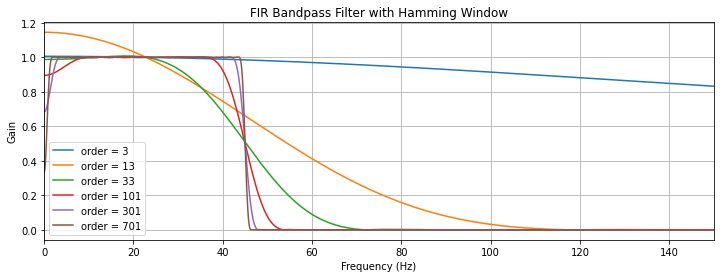

In [22]:
nyquist = F_s / 2
low = lowcut / nyquist
high = highcut / nyquist

plt.figure(figsize=(12, 4))

for order in [3,13,33,101,301,701]:
    fir_coeffs = firwin(order, [low,high], pass_zero=False, window="hamming")

    w, h = freqz(fir_coeffs, worN=2000)
    freq = w * F_s / (2 * np.pi)

    plt.plot(freq, abs(h), label=f'order = {order}')

plt.title('FIR Bandpass Filter with Hamming Window')
plt.xlabel('Frequency (Hz)')
plt.xlim(0,150)
plt.ylabel('Gain')
plt.grid()
plt.legend()
plt.show()

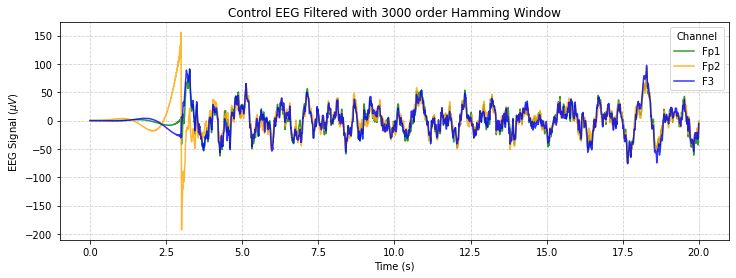

In [23]:
order = 3000

fir_coef = firwin(order, [low, high], pass_zero=False, window="hamming")

df_control_FIRfiltered = df_control.copy()

for col in df_control.columns:
    df_control_FIRfiltered[col] = lfilter(fir_coef, 1.0, df_control[col])

plot_EEG(df_control_FIRfiltered, "Control EEG Filtered with 3000 order Hamming Window")

Another problem arise when we have extremely high order: transient effect. Since we only have 20 seconds of data, if we use a FIR response, then for the first few seconds, the filter is still "warming up" and we lost 10% of our data just to initialize the filter itself.

## Butterworth Filter
Below is the Butterworth band-pass filter suggested from ["scipy-cookbook"](https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html). It also included a useful graph displaying how the order of butter reflected to the shape of the filter.

In [24]:
def butter_bandpass(lowcut, highcut, fs, order):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    y = filtfilt(b, a, data)
    return y

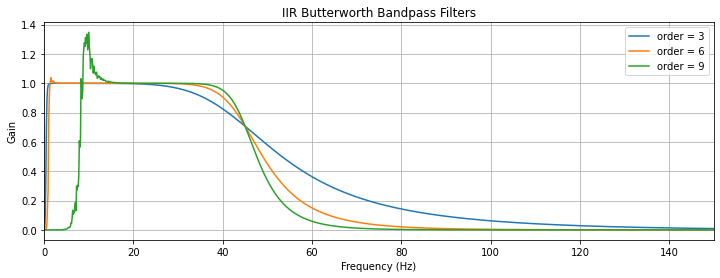

In [25]:
plt.figure(figsize=(12, 4))

for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, F_s, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((F_s * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.title('IIR Butterworth Bandpass Filters')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.xlim(0,150)
plt.grid(True)
plt.legend(loc='best')
plt.show()

Notice that when `order = 9`, there is a strange spike in the filter. This is likely because of the recursive calculation of the IIR filter. So in our actual filter, we used `order = 5` to prevent this from happening.

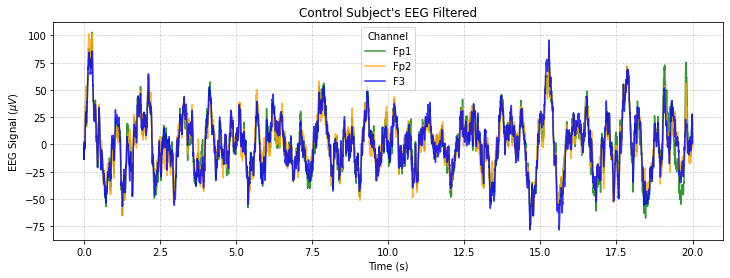

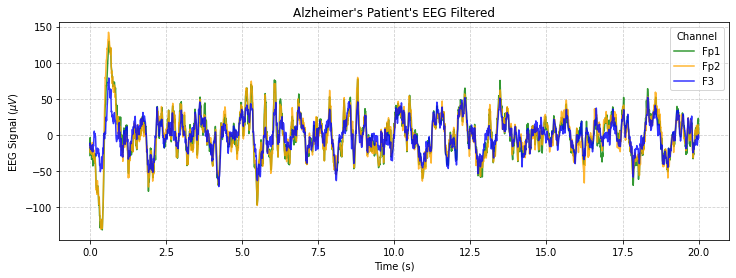

In [26]:
for col in df_control.columns:
    df_control[col] = butter_bandpass_filter(df_control[col], lowcut, highcut,F_s, order = 5)
for col in df_AD.columns:
    df_AD[col] = butter_bandpass_filter(df_AD[col], lowcut, highcut, F_s, order = 5)


plot_EEG(df_control, "Control Subject's EEG Filtered")
plot_EEG(df_AD, "Alzheimer's Patient's EEG Filtered")

# PSD Analysis

## Fourier Transform

To complement Welch's method, we use the Fast __Fourier Transform (FFT)__ which converts time-domain EEG signals into the frequency domain, allowing us to estimate the __Power Spectral Density (PSD)__. Unlike Welch's method, which averages overlapping segments of the signal to reduce noise, FFT-based PSD provides a direct computation with higher frequency resolution which may introduce more variability due to the lack of averaging. Both methods use the same spectral characteristics, which confirms the validity of our results and ensures that the observed EEG slowing in Alzheimer's patients is a strong finding.

First we define the function `compute_psd_fft()`, which calcluates the PSD by applying the FFT to the EEG signal, and then use `plot_PSD_fft()` to visualize the FFT-based PSD for each EEG channel (Fp1, Fp2, F3). This provides a frequency-domain representation of brain activity and allows us to compare spectral differences between Alzheimer's patients and control subjects.

In [27]:
def compute_psd_fft(signal, fs):
    N = len(signal)
    fft_vals = np.fft.rfft(signal)
    fft_freqs = np.fft.rfftfreq(N, d=1/fs)
    psd = (np.abs(fft_vals) ** 2) / N
    return fft_freqs, psd

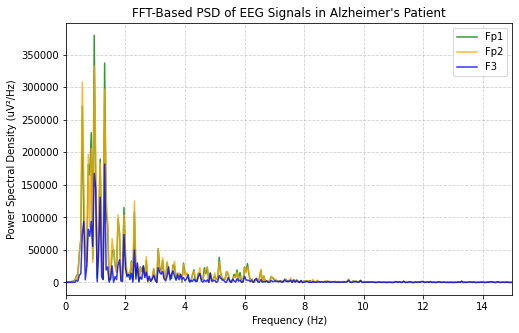

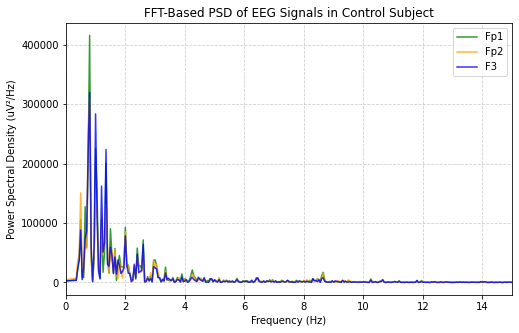

In [28]:
def plot_PSD_fft(df, title):
    freqs_Fp1, psd_Fp1 = compute_psd_fft(df["Fp1"].values, F_s)
    freqs_Fp2, psd_Fp2 = compute_psd_fft(df["Fp2"].values, F_s)
    freqs_F3, psd_F3 = compute_psd_fft(df["F3"].values, F_s)

    plt.figure(figsize=(8, 5))
    plt.plot(freqs_Fp1, psd_Fp1, label="Fp1", color="green", alpha=0.8)
    plt.plot(freqs_Fp2, psd_Fp2, label="Fp2", color="orange", alpha=0.8)
    plt.plot(freqs_F3, psd_F3, label="F3", color="blue", alpha=0.8)

    plt.xlabel("Frequency (Hz)")
    plt.xlim(0, 15)
    plt.ylabel("Power Spectral Density (uV²/Hz)")
    plt.title(title)
    plt.grid(linestyle="--", alpha=0.6)
    plt.legend()
    plt.show()

plot_PSD_fft(df_AD, "FFT-Based PSD of EEG Signals in Alzheimer's Patient")
plot_PSD_fft(df_control, "FFT-Based PSD of EEG Signals in Control Subject")

## Welch's Method

To analyze the and compare the EEG signals from Alzheimer's patients and control subjects, we do a Power Spectral Density (PSD) analysis. This will show us how power is distributed across different frequencies, revealing key features related to brain activity. To estimate the PSD, we use __Welch's Method__, which reduces noise and provides a smoother estimate by averaging multiple segments of the signal. This allows us to compare the power across different frequency bands while minimizing variability. 

We'll first create a function to calculate the PSD and plot the PSD for all 3 EEG channels (`Fp1`, `Fp2`, `F3`). 

In [29]:
def plot_PSD_welch(df, title, nperseg):
    freqs, psd_Fp1 = welch(df["Fp1"].values, fs=F_s, nperseg=nperseg)
    _, psd_Fp2 = welch(df["Fp2"].values, fs=F_s, nperseg=nperseg)
    _, psd_F3 = welch(df["F3"].values, fs=F_s, nperseg=nperseg)

    plt.figure(figsize=(8, 5))
    plt.plot(freqs, psd_Fp1, label="Fp1", color = "green", alpha=0.8)
    plt.plot(freqs, psd_Fp2, label="Fp2", color = "orange", alpha=0.8)
    plt.plot(freqs, psd_F3, label="F3", color = "blue", alpha=0.8)

    plt.xlabel("Frequency (Hz)")
    plt.xlim(0, 15)
    plt.ylabel(r"Power Spectral Density ($\mu V^2$/Hz)")
    plt.title(title)
    plt.grid(linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

Below are the results of the PSD analysis with Welch method.

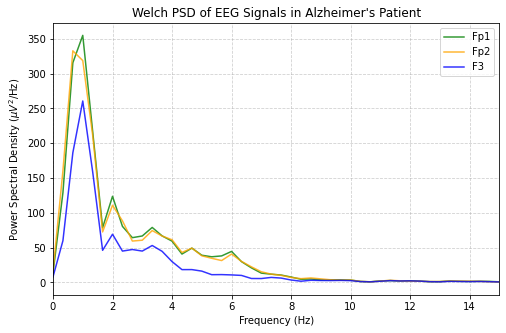

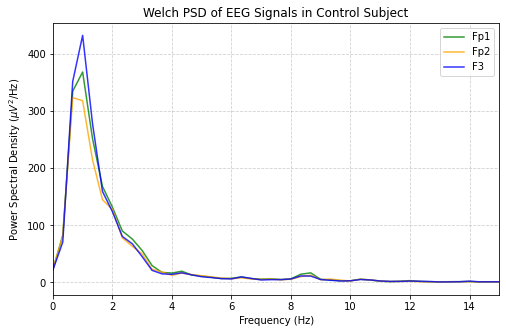

In [30]:
plot_PSD_welch(df_AD, "Welch PSD of EEG Signals in Alzheimer's Patient",1500)
plot_PSD_welch(df_control, "Welch PSD of EEG Signals in Control Subject", 1500)

# Conclusion